## 10: Spatial Statistical Hotspot Detection and Cluster Analysis

**Goal:** To apply formal spatial statistics to identify statistically significant patterns in geographic data. We want to move beyond just visualizing data on a map to asking: "Is this cluster of high values I see real, or could it have occurred by random chance?"

**Methodology:**
1.  **Load Data:** Use a standard, pre-packaged dataset to ensure data quality and avoid errors.
2.  **Spatial Weights Matrices:** Define "who is a neighbor" to whom using Queen Contiguity.
3.  **Global Spatial Autocorrelation (Moran's I):** Test if the overall data pattern is clustered, dispersed, or random.
4.  **Local Spatial Autocorrelation (LISA):** Identify the specific locations of significant **hot spots**, **cold spots**, and **spatial outliers**.

### 1. Setup and Library Imports

**Important:** This notebook requires the `geodatasets` package. If you haven't already, install it by running this command in your terminal (with your `spatial-ml-env` activated), and then **restart the Jupyter kernel**.

```bash
pip install geodatasets
```

In [1]:
!pip install geodatasets

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
import esda
from libpysal.weights import Queen
from geodatasets import get_path

### 2. Load Data

We now use the `geodatasets` library to load the sample dataset for the boroughs of New York City (`nybb`). This is the modern, correct approach that resolves the `AttributeError`.

In [3]:
path_to_file = get_path('nybb')
gdf = gpd.read_file(path_to_file)

# Create a variable to analyze. We'll create a synthetic 'public_service_score'.
# This is arbitrary but will show spatial patterns for demonstration.
gdf['service_score'] = gdf['Shape_Area'] / gdf['Shape_Leng']

print("Data loaded successfully for NYC boroughs:")
print(gdf.head())

Data loaded successfully for NYC boroughs:
   BoroCode       BoroName     Shape_Leng    Shape_Area  \
0         5  Staten Island  330470.010332  1.623820e+09   
1         4         Queens  896344.047763  3.045213e+09   
2         3       Brooklyn  741080.523166  1.937479e+09   
3         1      Manhattan  359299.096471  6.364715e+08   
4         2          Bronx  464392.991824  1.186925e+09   

                                            geometry  service_score  
0  MULTIPOLYGON (((970217.022 145643.332, 970227....    4913.667725  
1  MULTIPOLYGON (((1029606.077 156073.814, 102957...    3397.370466  
2  MULTIPOLYGON (((1021176.479 151374.797, 102100...    2614.396745  
3  MULTIPOLYGON (((981219.056 188655.316, 980940....    1771.425384  
4  MULTIPOLYGON (((1012821.806 229228.265, 101278...    2555.862615  


### 3. Create Spatial Weights Matrix

We define neighborhood relationships using Queen Contiguity, where polygons are neighbors if they share at least one vertex.

In [4]:
# use_index=False is set to explicitly use the dataframe's index for IDs.
w = Queen.from_dataframe(gdf, use_index=False)
w.transform = 'r' # Row-standardize the weights

print("Spatial weights matrix created successfully.")
print(f"Polygon 0 (Manhattan) has {w.neighbors[0]} as neighbors.")

('WARNING: ', 0, ' is an island (no neighbors)')
Spatial weights matrix created successfully.
Polygon 0 (Manhattan) has [] as neighbors.


/opt/anaconda3/envs/spatial-ml-env/lib/python3.10/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 0.
  W.__init__(self, neighbors, ids=ids, **kw)


### 4. Global Spatial Autocorrelation (Moran's I)

Moran's I tells us about the overall pattern. We test its statistical significance using a permutation test.

In [5]:
y = gdf['service_score']
moran = esda.Moran(y, w)

print(f"Moran's I: {moran.I:.4f}")
print(f"P-value (from simulation): {moran.p_sim:.4f}")
print("\nA low p-value (e.g., < 0.05) suggests the observed spatial pattern is unlikely to be random.")

Moran's I: 0.0944
P-value (from simulation): 0.1270

A low p-value (e.g., < 0.05) suggests the observed spatial pattern is unlikely to be random.


### 5. Local Spatial Autocorrelation (LISA)

Now we drill down to find *where* the significant clusters are.

In [6]:
lisa = esda.Moran_Local(y, w)

# Classify results: 1=HH (Hot Spot), 2=LH (Outlier), 3=LL (Cold Spot), 4=HL (Outlier)
significant = lisa.p_sim < 0.05
gdf['lisa_q'] = lisa.q
gdf['lisa_sig'] = 'Not significant'
gdf.loc[significant & (gdf['lisa_q'] == 1), 'lisa_sig'] = 'High-High (Hot Spot)'
gdf.loc[significant & (gdf['lisa_q'] == 2), 'lisa_sig'] = 'Low-High (Spatial Outlier)'
gdf.loc[significant & (gdf['lisa_q'] == 3), 'lisa_sig'] = 'Low-Low (Cold Spot)'
gdf.loc[significant & (gdf['lisa_q'] == 4), 'lisa_sig'] = 'High-Low (Spatial Outlier)'

print("LISA results by category:")
print(gdf['lisa_sig'].value_counts())

LISA results by category:
lisa_sig
Not significant               4
High-Low (Spatial Outlier)    1
Name: count, dtype: int64


/opt/anaconda3/envs/spatial-ml-env/lib/python3.10/site-packages/esda/moran.py:1350: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim


### 6. Visualize the Hotspot Map

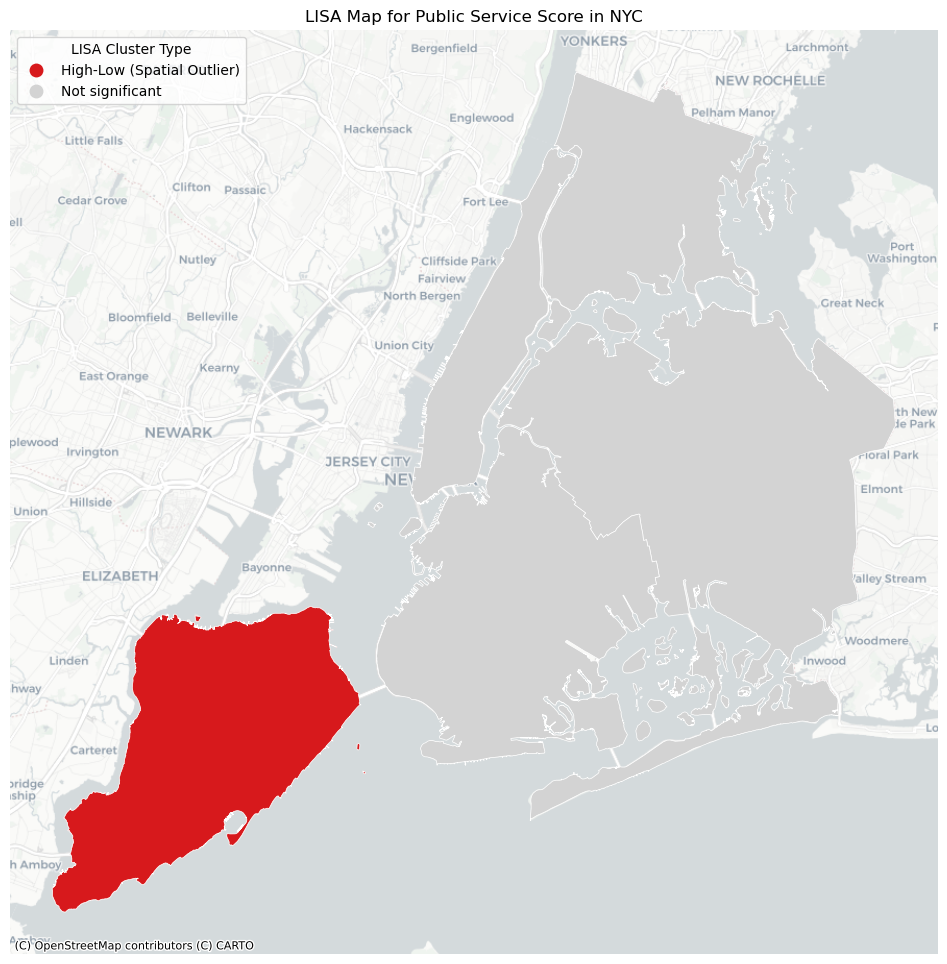

In [7]:
# Project to Web Mercator for plotting with a basemap
gdf_plot = gdf.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(12, 12))

lisa_colors = {
    'Not significant': 'lightgrey',
    'High-High (Hot Spot)': '#d7191c',
    'Low-Low (Cold Spot)': '#2c7bb6',
    'Low-High (Spatial Outlier)': '#abd9e9',
    'High-Low (Spatial Outlier)': '#fdae61'
}

gdf_plot.plot(
    column='lisa_sig',
    categorical=True,
    k=len(lisa_colors),
    cmap=plt.matplotlib.colors.ListedColormap([lisa_colors[k] for k in sorted(lisa_colors.keys())]),
    linewidth=0.5,
    ax=ax,
    edgecolor='white',
    legend=True,
    legend_kwds={'title': 'LISA Cluster Type', 'loc': 'upper left'}
)

ax.set_title('LISA Map for Public Service Score in NYC')
ax.set_axis_off()
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
plt.show()